In [16]:
import numpy as np
import matplotlib.pyplot as plt

from robot_utils.robot_data.img_data import ImgData
from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform

import sys
sys.path.append("/home/masonbp/ford/fastsam3d")

from segment_track.observation import Observation
from segment_track.segment import Segment
from segment_track.tracker import Tracker
from segment_track.fastsam_wrapper import FastSAMWrapper

from object_map_registration.object.object import Object
from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.register.clipper_pt_registration import ClipperPtRegistration
from object_map_registration.register.dist_vol_sim_reg import DistVolSimReg

In [2]:
bag = "/home/masonbp/data/motlee_jan_2024/00/RR08.bag"
img_data = ImgData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/d455/color/image_raw/compressed",
    time_tol=.0333333,
)
pose_data = PoseData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/world",
    time_tol=.4,
    interp=True
)
t0 = np.max([img_data.t0, pose_data.t0])
img_data.set_t0(img_data.t0 - t0)
pose_data.set_t0(pose_data.t0 - t0)

<Axes: xlabel='x', ylabel='y'>

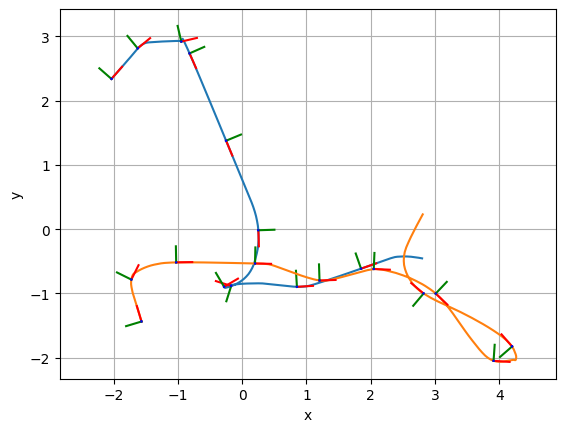

In [3]:
pose_data.plot2d(t0=100, tf=120, pose=False, dt=.1)
pose_data.plot2d(t0=100, tf=120, trajectory=False, pose=True, dt=2., axis_len=.25)
pose_data.plot2d(t0=200, tf=220, pose=False, dt=.1)
pose_data.plot2d(t0=200, tf=220, trajectory=False, pose=True, dt=2., axis_len=.25)
# pose_data.plot2d(t0=t0, tf=tf, trajectory=True, pose=True, dt=2., axis_len=.25)

In [4]:
# T_BC = np.array([
#     - 0.0075156724929106855, 0.052520932013504995, 0.9985915413057593, 0.2101108603826516, - -0.999948500695071, -0.00641591694631477, 0.007863330555028802, 
#     -0.012497043173790775, - 0.00681986984179056, -0.9985992127526291, 0.05247000729150186, -0.0018691769405706252, - 0.0, 0.0, 0.0, 1.0
# ]).reshape((4, 4))

T_BC = np.array([0.031700555562911625, -0.03613229685936231, -0.9988440978954973, -0.3474637078784243, 0.9994936165740449, 
                 0.003899694308407531, 0.03158010152037666, -0.006910240015390966, 0.0027541250405664908, -0.9993394065621388, 0.03623762253919305, -0.11367298866636036, 0.0, 0.0, 0.0, 1.0
]).reshape((4, 4))
pose_data.T_postmultiply = T_BC
img_data.extract_params("/RR08/d455/color/camera_info")
cam_params = img_data.camera_params
fastsam = FastSAMWrapper(
    weights="/home/masonbp/tools/fastsam/weights/FastSAM-x.pt",
    imgsz=256,
    device='cpu'
)
img_area = cam_params.width * cam_params.height
fastsam.setup_filtering(
    ignore_people=True,
    yolo_det_img_size=(128, 128),
    allow_tblr_edges=[True, False, False, False],
    area_bounds=[img_area / 20**2, img_area / 3**2]
)


Fusing layers... 


In [5]:
all_observations = [[], []]
ts = [[100, 120], [200, 220]]
for i in range(2):
    for t in np.arange(ts[i][0], ts[i][1], .05):
        try:
            img = img_data.img(t)
            pose = pose_data.T_WB(t)
        except:
            continue
        observations = fastsam.run(t, pose, img)
        all_observations[i].append(observations)
        
# print(segment.observations)
# print(len(segment.observations))


/home/masonbp/.envs/sparse_map/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

0: 160x256 8 objects, 87.6ms
Speed: 1.6ms preprocess, 87.6ms inference, 16.0ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 9 objects, 74.9ms
Speed: 0.3ms preprocess, 74.9ms inference, 17.3ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 8 objects, 75.2ms
Speed: 0.3ms preprocess, 75.2ms inference, 12.8ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 9 objects, 75.1ms
Speed: 3.9ms preprocess, 75.1ms inference, 14.4ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 7 objects, 74.2ms
Speed: 4.2ms preprocess, 74.2ms inference, 11.5ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 7 objects, 75.3ms

In [6]:
trackers = [Tracker(
    camera_params=cam_params,
    pixel_std_dev=10.0,
    min_iou=0.5,
    min_sightings=3,
    max_t_no_sightings=0.25
) for _ in range(2)]

for i in range(2):
    for observations in all_observations[i]:
        if len(observations) > 0:
            trackers[i].update(observations[0].time, observations)


In [7]:
boxes = np.array([
    [2.33, -2.03], [2.16, -1.65], [4.2, 0.5], [4.48, 1.73], [5.05, 3.24], [5.42, 3.43], 
    [2.28, 1.94], [1.98, 2.19], [0.41, 2.39], [0.07, 2.64], [1.03, .48], [-1., 1.63], 
    [-.86, -1.42], [-.33, -1.83], [-.73, -1.97], [-0.3, -3.46], [-1.79, 0.5], [-1.89, 1.13], 
    [-2.86, 2.74], [-2.61, 2.78], [-3.37, 0.67], [-3.03, 0.19], [-2.36, -1.52],
])

missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one


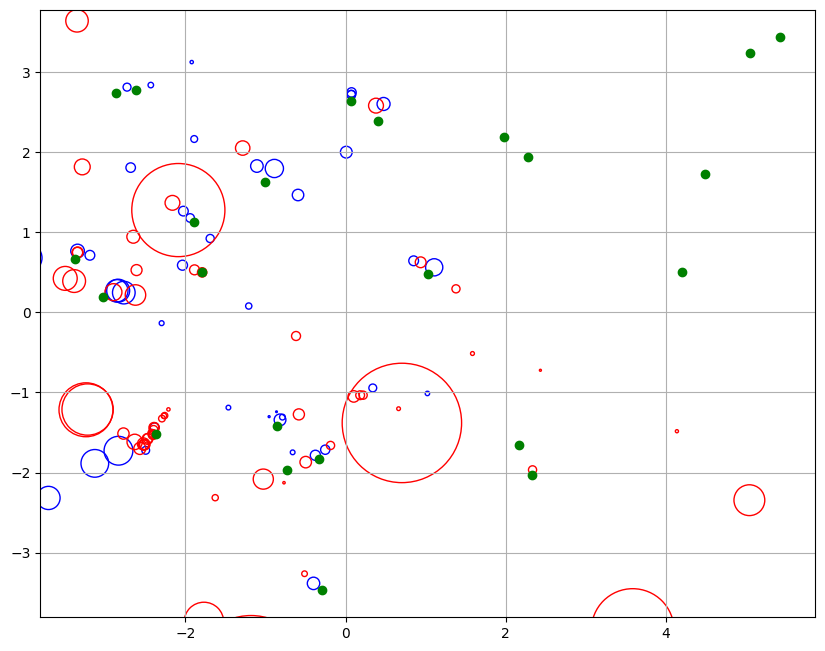

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(boxes[:,0], boxes[:,1], 'go')
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
maps = [[], []]

formats = ['bx', 'r+']
colors = ['blue', 'red']

for i in range(2):
    for segment in trackers[i].segments + trackers[i].segment_graveyard:
        try:
            reconstruction = segment.reconstruction3D(width_height=True)
            position, width = reconstruction[:2], reconstruction[3]
            ellipsoid = Ellipsoid(reconstruction[:2], axes=np.array([width/2, width/2]), rot_mat=np.eye(2))
            maps[i].append(ellipsoid)
            maps[i][-1].plot2d(ax, edgecolor=colors[i])
        except:
            print("missed this one")

In [19]:
clipper = ClipperPtRegistration(sigma=.2, epsilon=.4)
inliers = clipper.register(maps[0], maps[1])
print(inliers)

[[31 25]
 [32 34]
 [49 26]
 [37 38]
 [ 5 29]
 [53 19]
 [58 70]
 [23 81]
 [51 12]
 [25 82]
 [45 54]
 [24 68]
 [34 60]]


In [17]:
dist_vol_reg = DistVolSimReg(sigma=.2, epsilon=.4)
inliers = dist_vol_reg.register(maps[0], maps[1])
print(inliers)

[[43 11]
 [43 11]
 [43 11]
 ...
 [ 0  2]
 [ 0  1]
 [ 0  0]]


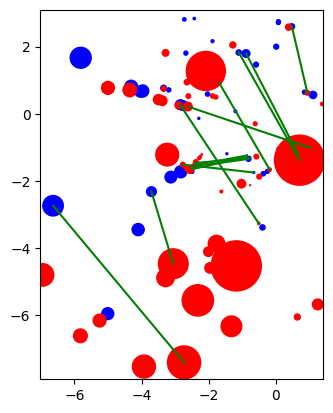

In [20]:
fig, ax = plt.subplots()
colors = ['blue', 'red']

for i in range(2):
    for obj in maps[i]:
        ax = obj.plot2d(ax, color=colors[i])

for pair in inliers:
    ax.plot([maps[0][pair[0]].centroid[0], maps[1][pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], maps[1][pair[1]].centroid[1]], 'g-')

ax.set_aspect('equal', adjustable='box')
